In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
import os
from scipy import ndimage

In [2]:
!ls '../rsfMRI-0'

attention_maps_v1.3-rsfMRI_0-patch=5-Copy1.ipynb
attention_maps_v1.3-rsfMRI_0-patch=5.ipynb
attention_maps_v1.3-rsfmri_0-patch=2.ipynb
outUpCropMeanS_rsfMRI-0_p2.npy
outUpCropMeanS_rsfMRI-0_p5.npy


In [3]:
p2 = np.load('../rsfMRI-0/outUpCropMeanS_rsfMRI-0_p2.npy', allow_pickle=True).astype(float)
p5 = np.load('../rsfMRI-0/outUpCropMeanS_rsfMRI-0_p5.npy', allow_pickle=True).astype(float)

In [4]:
!ls '../average_maps/'

MNI152_T1_1mm_brain_mask_dil.nii.gz   rsfmri_0_difference_volume.nii.gz
MNI152_T1_2mm_brain_mask_dil1.nii.gz  tbss_FA_difference_volume.nii.gz
T1_nonlinear_difference_volume.nii.gz tbss_FA_s_difference_volume.nii.gz
T2_lesions_difference_volume.nii.gz   tracts_difference_volume.nii.gz


In [5]:
scaling_values = '../../../../../SwinAgeMapper/datasets/scaling_values_simple.csv'
X_path = '24237795'
modality_flag = 'rsfmri_0'

def processs_inputs(modality_flag='T1_nonlinear',
                    subject_path='24237795',
                    X_volume = None,
                    X_resolution = None
                   ):
    
    scaling_values_simple = pd.read_csv(scaling_values, index_col=0)
    scale_factor = scaling_values_simple.loc[modality_flag].scale_factor
    resolution = scaling_values_simple.loc[modality_flag].resolution
    
    if resolution == '2mm':
        crop_values = [5, 85, 6, 102, 0, 80]
    else:
        crop_values = [10, 170, 12, 204, 0, 160]

    if X_volume is None:
        
        data_file = os.path.basename(scaling_values_simple.loc[modality_flag].data_file)
        X_path = '../../../../multi-age-mapper/additional_data_examples/' + subject_path + '/' + data_file

        if data_file == 'dr_stage2.nii.gz':
            X_volume = np.array(nib.load(X_path).dataobj)[:,:,:,0]
        else:
            X_volume = np.array(nib.load(X_path).dataobj)

   
        X_volume = X_volume[crop_values[0]:crop_values[1],
                            crop_values[2]:crop_values[3], 
                            crop_values[4]:crop_values[5]]
    
        non_deterministic_modalities = ['T1_nonlinear', 'T1_linear', 'T2_nonlinear']
        if modality_flag in non_deterministic_modalities:
            X_volume = X_volume / X_volume.mean()       

        X_volume = X_volume / scale_factor
        
    else:
        
        mask = nib.load('../average_maps/MNI152_T1_1mm_brain_mask_dil.nii.gz').get_fdata()
        
        if modality_flag == 'rsfmri_0':
            mask = nib.load('../average_maps/MNI152_T1_2mm_brain_mask_dil1.nii.gz').get_fdata()
        
        X_volume = X_volume * mask
        
        X_volume = X_volume[crop_values[0]:crop_values[1],
                            crop_values[2]:crop_values[3], 
                            crop_values[4]:crop_values[5]]
    
    return X_volume

baseline = processs_inputs(subject_path = X_path, modality_flag=modality_flag)
average = nib.load('../average_maps/rsfmri_0_difference_volume.nii.gz').get_fdata()
average = processs_inputs(X_volume=average, modality_flag=modality_flag)

In [6]:
print(average.shape)
print(p2.shape)
print(p5.shape)
print(baseline.shape)

(80, 96, 80)
(8, 160, 192, 160)
(6, 160, 192, 160)
(80, 96, 80)


In [7]:

if modality_flag == 'rsfmri_0':
    import torch
    Upsample = torch.nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
    average = Upsample(torch.unsqueeze(torch.unsqueeze(torch.tensor(average), dim=0), dim=0))
    average = torch.squeeze(average).numpy().copy()
    baseline = Upsample(torch.unsqueeze(torch.unsqueeze(torch.tensor(baseline), dim=0), dim=0))
    baseline = torch.squeeze(baseline).numpy().copy()

print(average.shape)
print(p2.shape)
print(p5.shape)
print(baseline.shape)

(160, 192, 160)
(8, 160, 192, 160)
(6, 160, 192, 160)
(160, 192, 160)


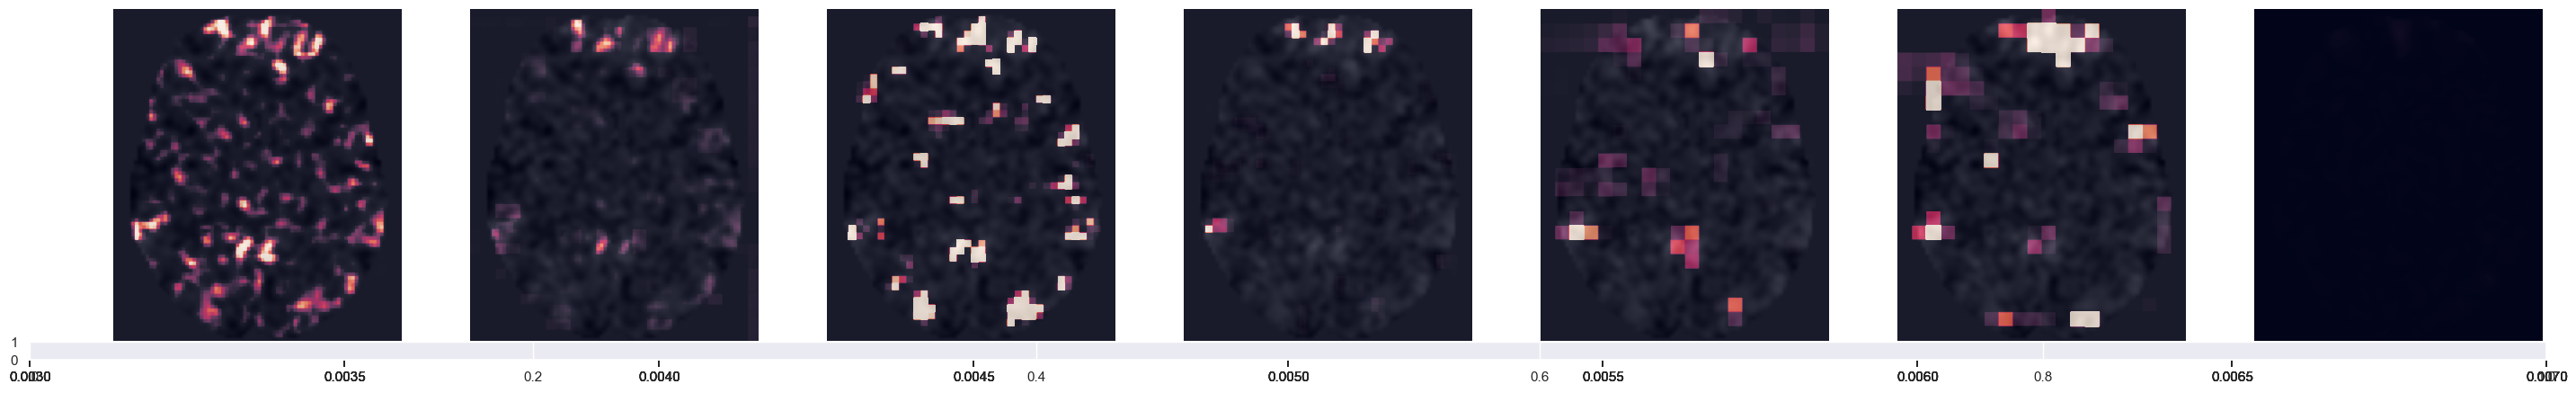

In [8]:
# img = p2[0]
vmin=0.003
vmax=0.007
cmap=None

fig, axs = plt.subplots(1,7, figsize=(35,5))
axs = axs.flatten()

caxs = [fig.add_axes([0.1, 0.1, 0.8, 0.04]) for i in range(7)] # to add colorbars

for i in range(6):
    im = axs[i].imshow(ndimage.rotate(baseline[:,:,80], 90), cmap='gray')
    im = axs[i].imshow(ndimage.rotate(p2[i,:,:,80], 90), cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.75)
    axs[i].grid()
    axs[i].axis('off');
    fig.colorbar(im, cax=caxs[i], orientation='horizontal')


# im = axs[6].imshow(ndimage.rotate(baseline[:,:,80], 90), cmap='gray')
im = axs[6].imshow(ndimage.rotate(np.abs(average[:,:,80]), 90), vmax=100)
axs[6].grid()
axs[6].axis('off');

In [9]:
plt.imshow(ndimage.rotate(np.abs(average[:,:,80]), 90), vmax=1.5)
print(average.min(), average.max())

-2.9750474793729103 5.8896627329076985


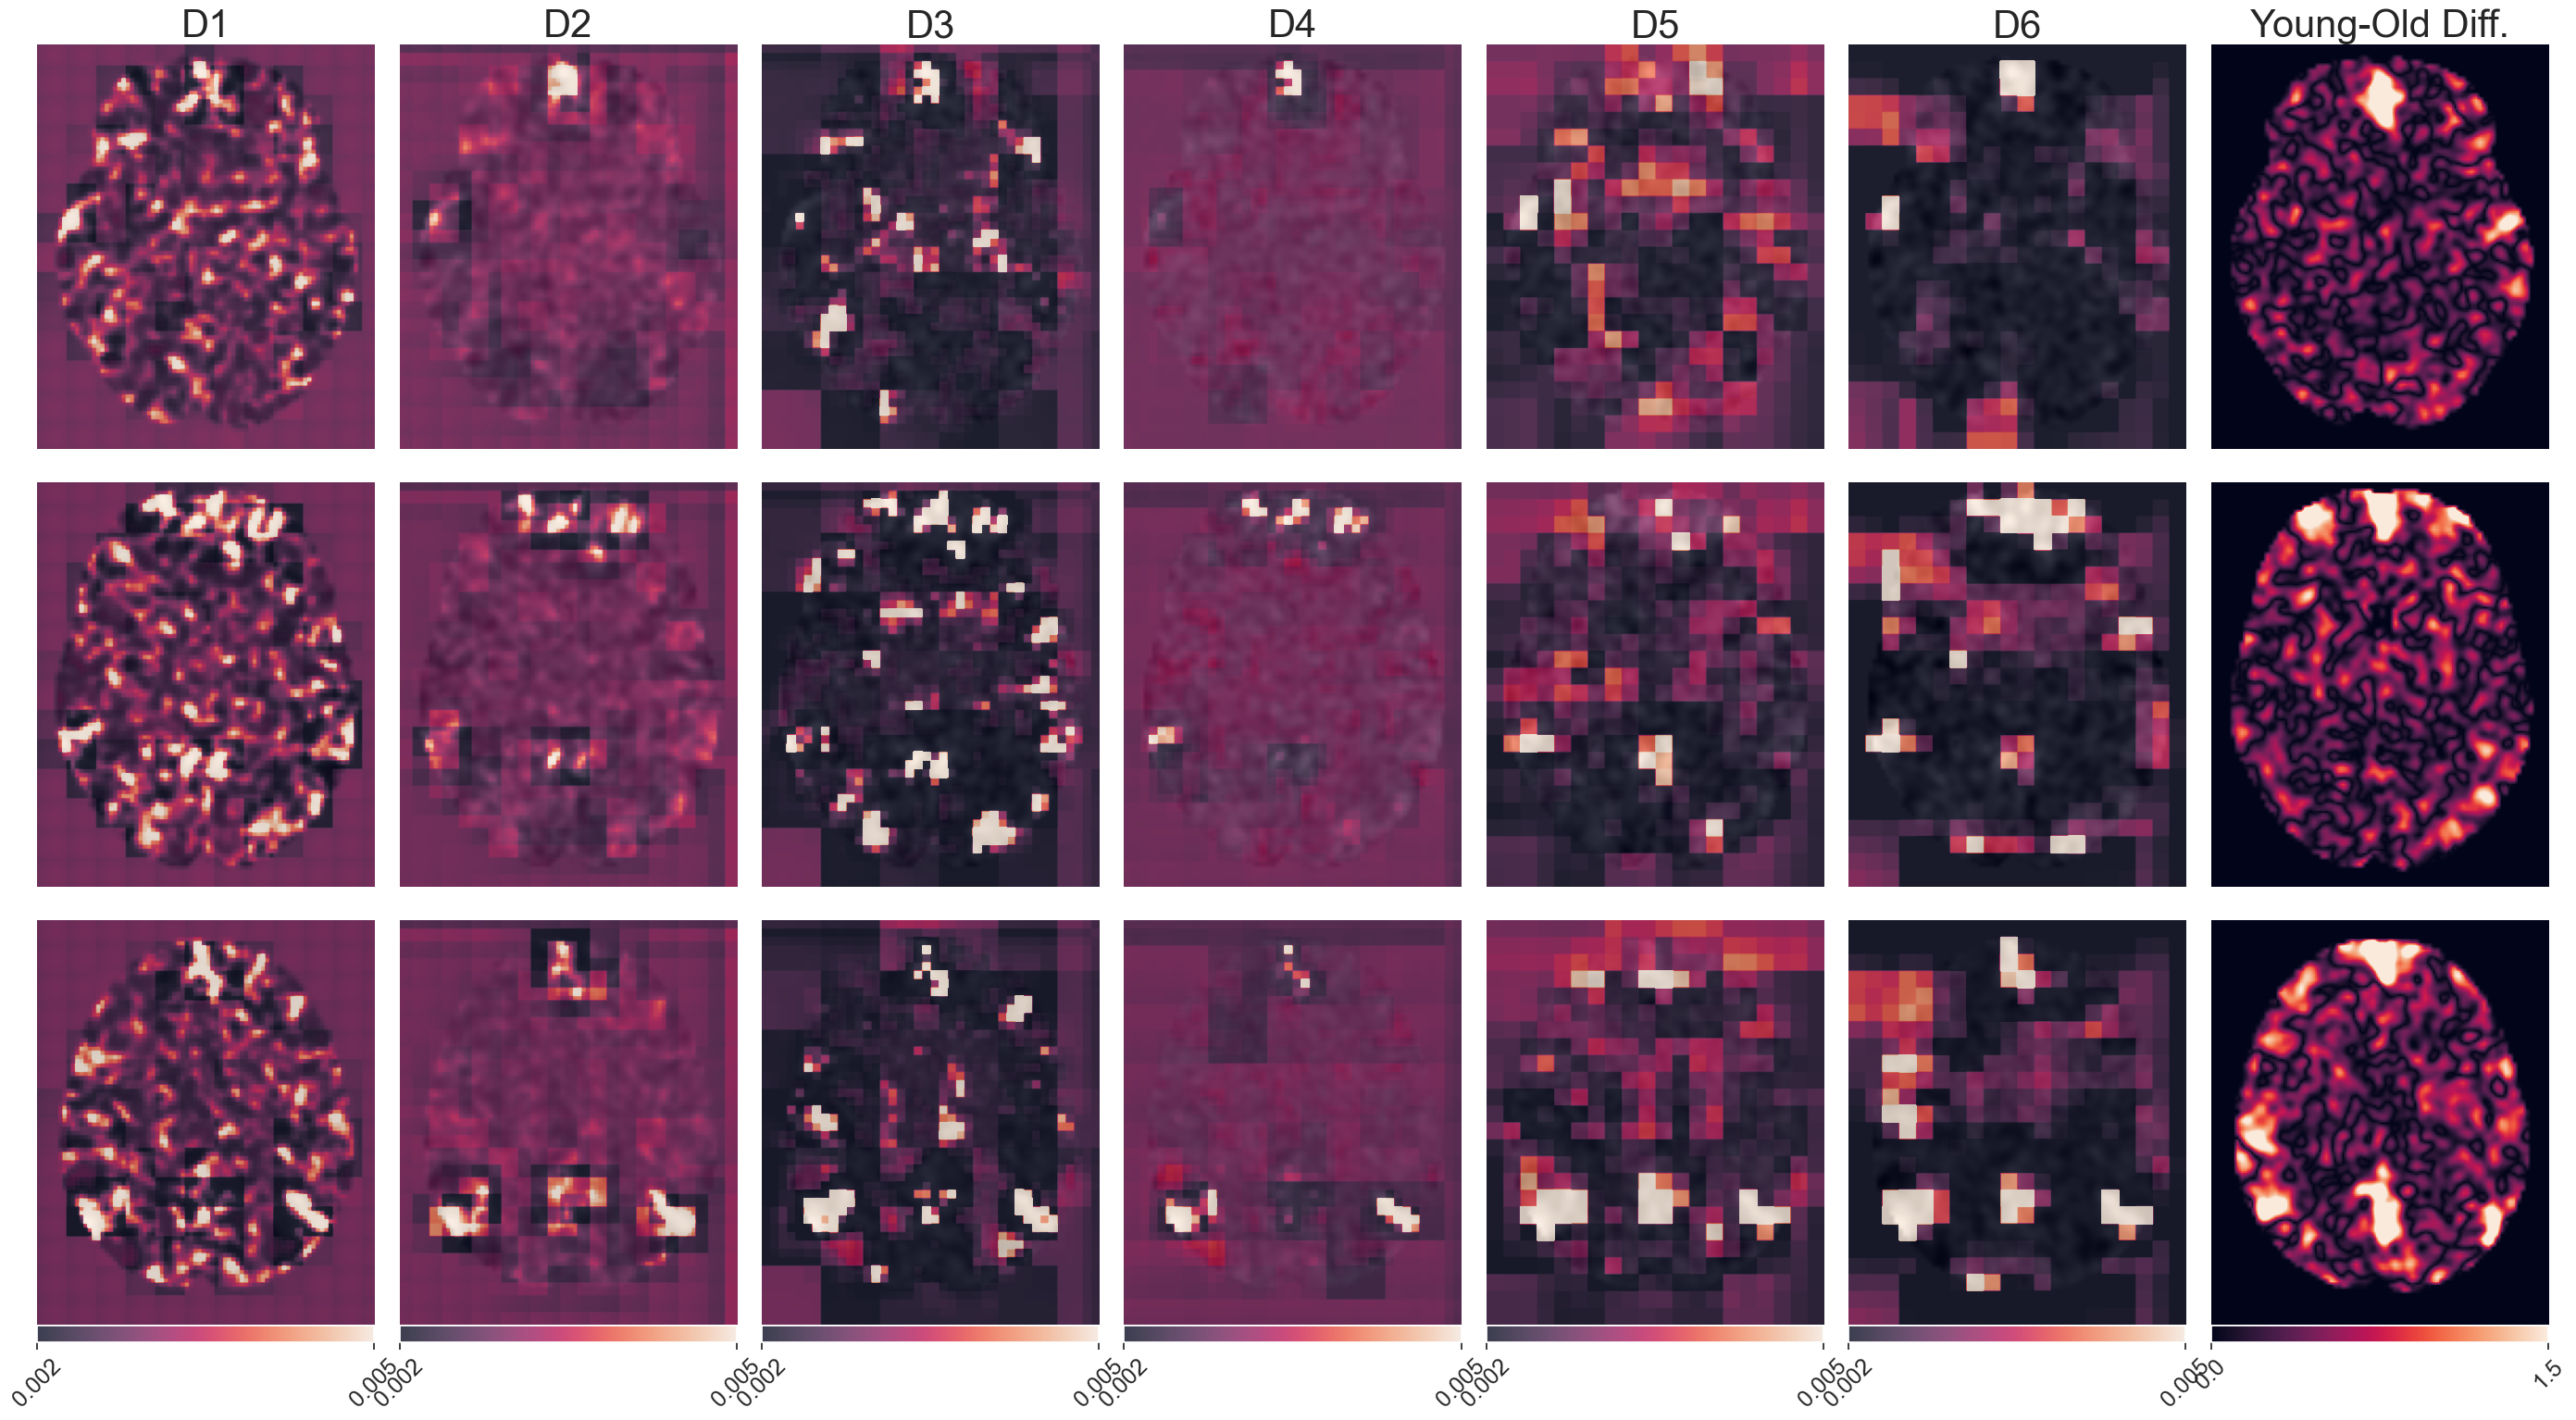

In [10]:
##### import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

vmin=0.002
vmax=0.005
cmap=None
vmaxB = 1.5

title_font_size=30
tick_font_size=18

fig, axs = plt.subplots(3,7, figsize=(35,18))
axs = axs.flatten()

titles = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'Young-Old Diff.']

step = 20

for i in range(6):
    im = axs[i].imshow(ndimage.rotate(baseline[:,:,80-step], 90), cmap='gray')
    im = axs[i].imshow(ndimage.rotate(p2[i,:,:,80-step], 90), cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.75)
    axs[i].grid()
    axs[i].axis('off')
    axs[i].set_title(titles[i], fontsize=title_font_size)

im2 = axs[6].imshow(ndimage.rotate(np.abs(average[:,:,80-step]), 90), vmax=vmaxB) #vmin=-100, vmax=200)
axs[6].grid()
axs[6].axis('off')
axs[6].set_title(titles[6], fontsize=title_font_size)

for i in range(7,13):
    im = axs[i].imshow(ndimage.rotate(baseline[:,:,80], 90), cmap='gray')
    im = axs[i].imshow(ndimage.rotate(p2[i-7,:,:,80], 90), cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.75)
    axs[i].grid()
    axs[i].axis('off')
    
im2 = axs[13].imshow(ndimage.rotate(np.abs(average[:,:,80]), 90), vmax=vmaxB)
axs[13].grid()
axs[13].axis('off')

fig.subplots_adjust(wspace=0.075, hspace=0.075)
fig.canvas.draw()

for i in range(14,20):
    im = axs[i].imshow(ndimage.rotate(baseline[:,:,80+step], 90), cmap='gray')
    im = axs[i].imshow(ndimage.rotate(p2[i-14,:,:,80+step], 90), cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.75)
    axs[i].grid()
    axs[i].axis('off')
    
    bbox = axs[i].get_tightbbox(fig.canvas.get_renderer())
    left, bottom, width, height = bbox.x0 / fig.bbox.width, bbox.y0 / fig.bbox.height, bbox.width / fig.bbox.width, bbox.height / fig.bbox.height  # get the updated position of subplot
    colorbar_axes = fig.add_axes([left, 0.1, width, 0.01])  # use left and width to align colorbar with subplot
    
    cbar = fig.colorbar(im, cax=colorbar_axes, orientation='horizontal') # create colorbar in manually set axes
    cbar.ax.tick_params(labelsize=tick_font_size, rotation=45) # adjust the font size here
    cbar.set_ticks([vmin, vmax])  # set colorbar to only show min and max values

im2 = axs[20].imshow(ndimage.rotate(np.abs(average[:,:,80+step]), 90), vmax=vmaxB)
axs[20].grid()
axs[20].axis('off')

bbox = axs[20].get_tightbbox(fig.canvas.get_renderer())
left, bottom, width, height = bbox.x0 / fig.bbox.width, bbox.y0 / fig.bbox.height, bbox.width / fig.bbox.width, bbox.height / fig.bbox.height  # get the updated position of last subplot
colorbar_axes = fig.add_axes([left, 0.1, width, 0.01])  # use left and width to align colorbar with subplot

cbar = fig.colorbar(im2, cax=colorbar_axes, orientation='horizontal') # create colorbar in manually set axes
cbar.ax.tick_params(labelsize=tick_font_size, rotation=45) # adjust the font size here
cbar.set_ticks([0, vmaxB])  # set colorbar to only show min and max values

plt.show()

fig.savefig('rsfMRI0_p2_viz.png', bbox_inches='tight', facecolor='white')


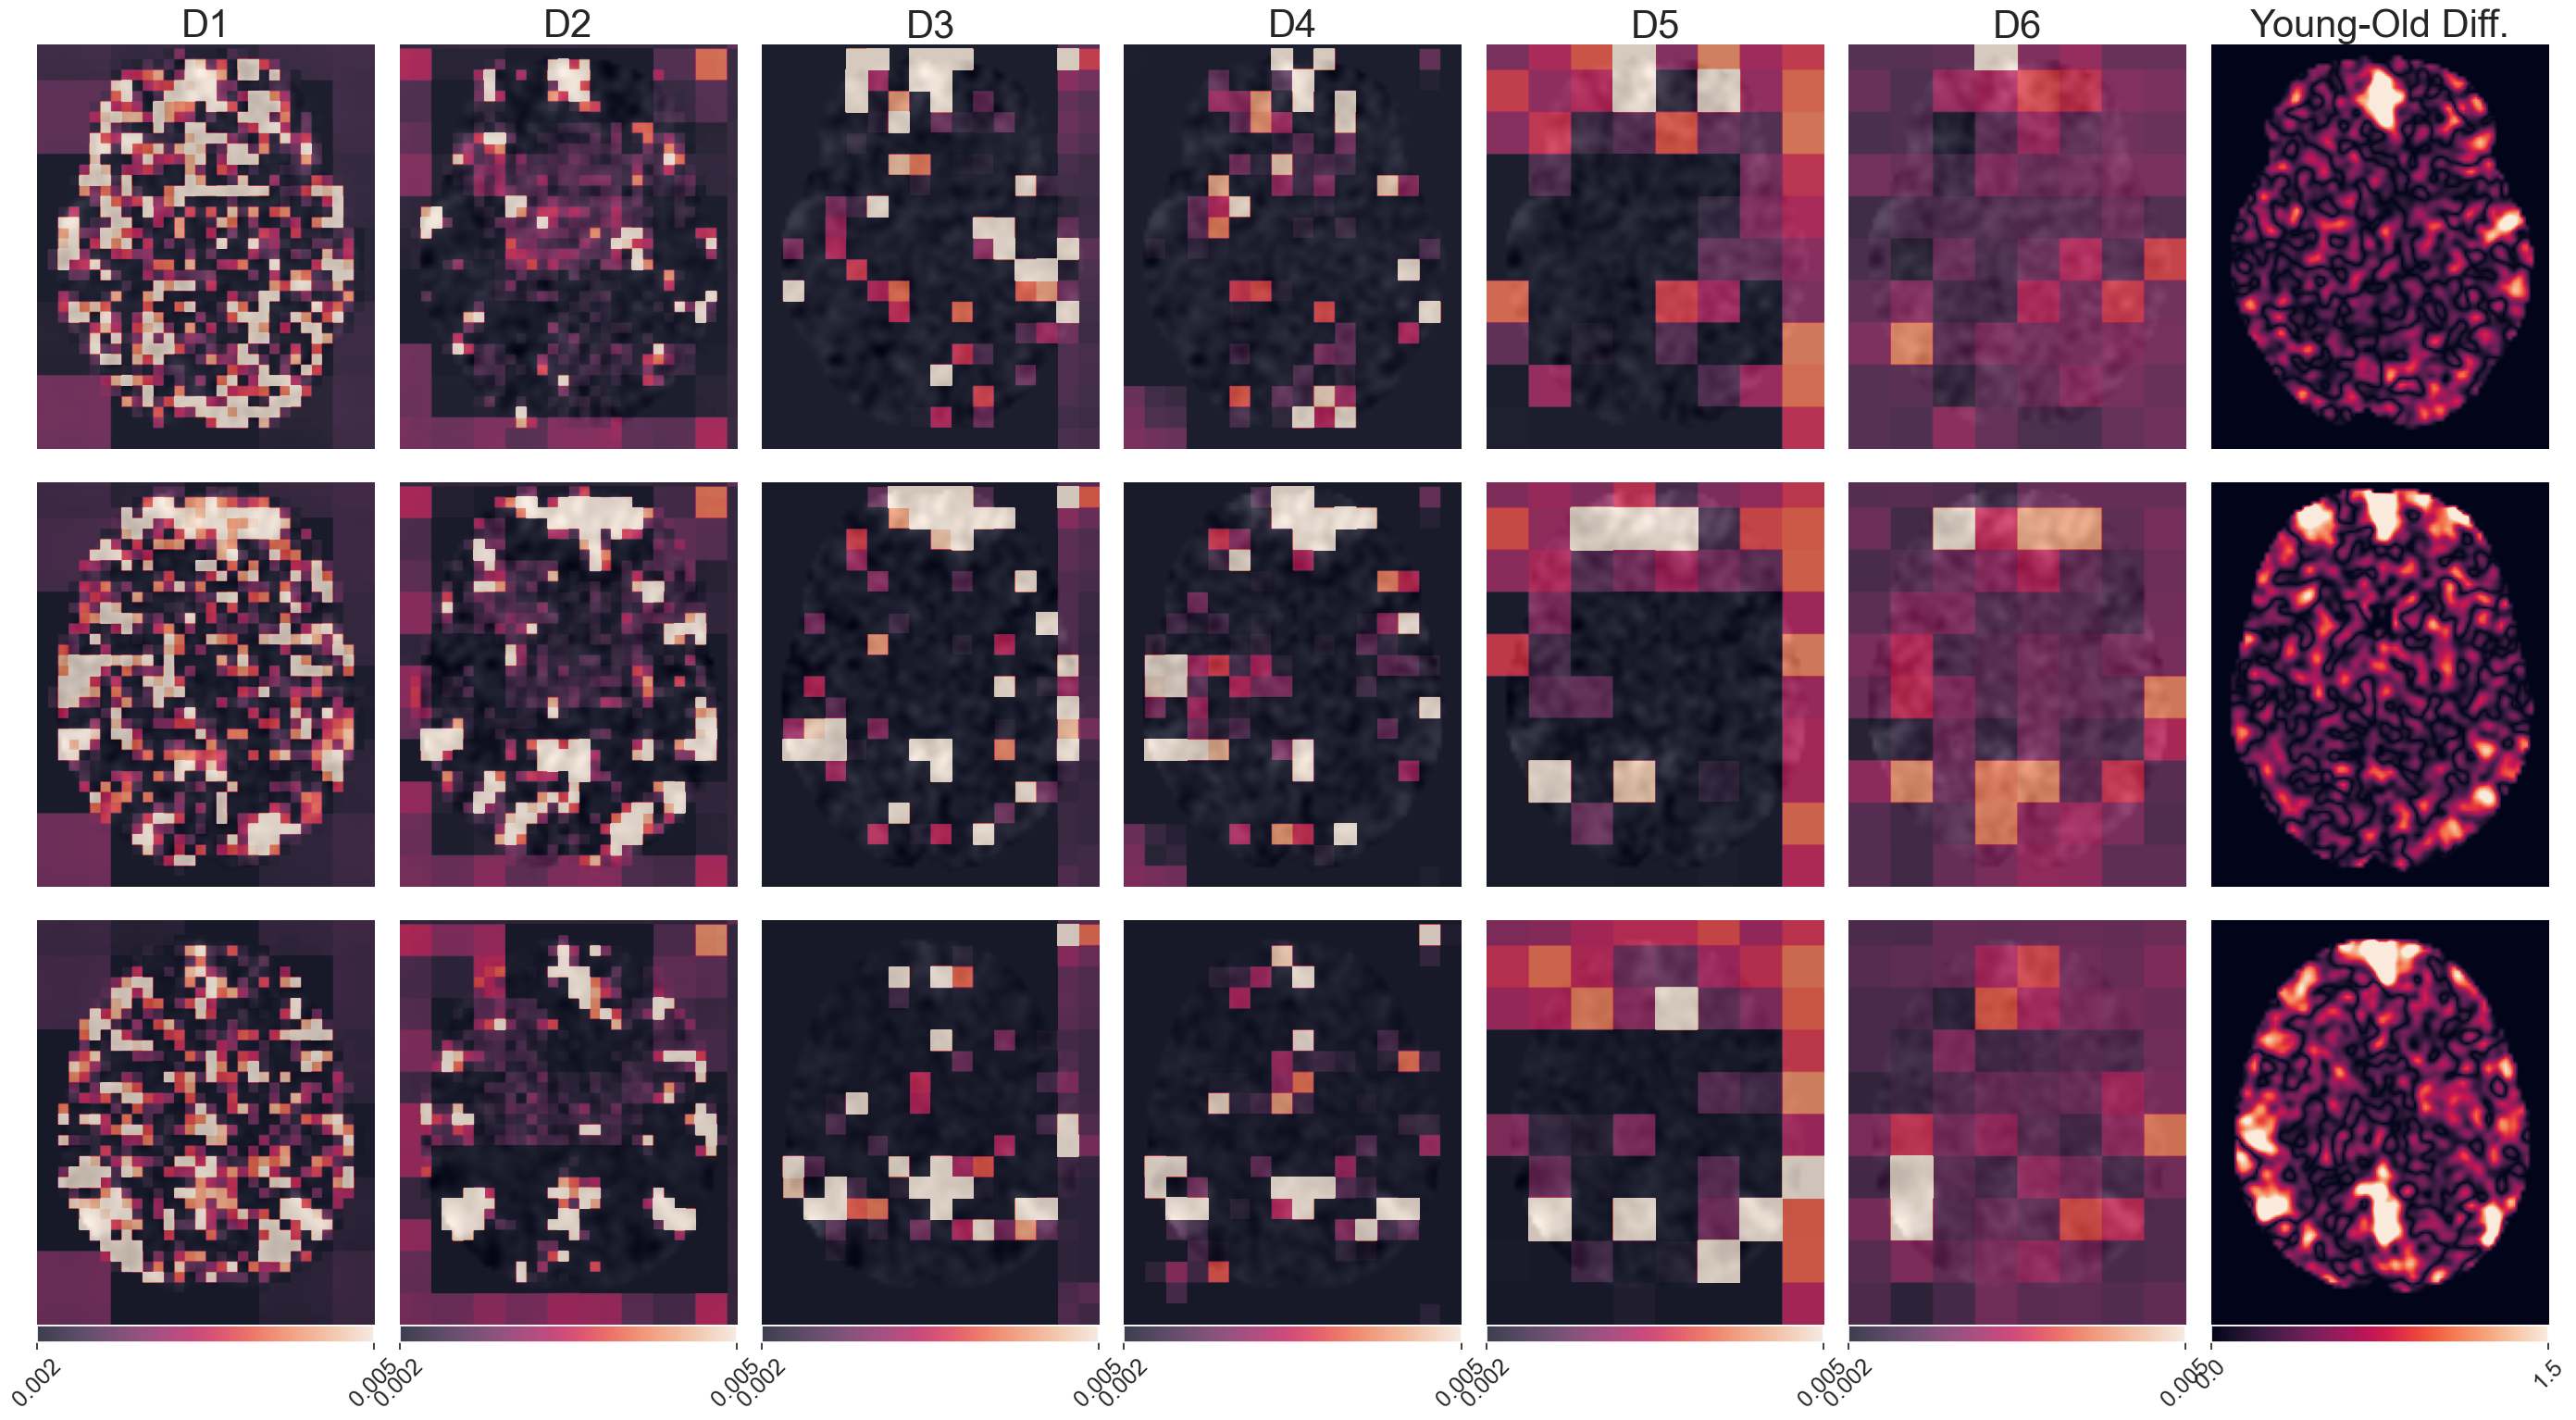

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

vmin=0.002
vmax=0.005
cmap=None
vmaxB = 1.5

title_font_size=30
tick_font_size=18

fig, axs = plt.subplots(3,7, figsize=(35,18))
axs = axs.flatten()

titles = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'Young-Old Diff.']

step = 20

for i in range(6):
    im = axs[i].imshow(ndimage.rotate(baseline[:,:,80-step], 90), cmap='gray')
    im = axs[i].imshow(ndimage.rotate(p5[i,:,:,80-step], 90), cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.75)
    axs[i].grid()
    axs[i].axis('off')
    axs[i].set_title(titles[i], fontsize=title_font_size)

im2 = axs[6].imshow(ndimage.rotate(np.abs(average[:,:,80-step]), 90), vmax=vmaxB) #vmin=-100, vmax=200)
axs[6].grid()
axs[6].axis('off')
axs[6].set_title(titles[6], fontsize=title_font_size)

for i in range(7,13):
    im = axs[i].imshow(ndimage.rotate(baseline[:,:,80], 90), cmap='gray')
    im = axs[i].imshow(ndimage.rotate(p5[i-7,:,:,80], 90), cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.75)
    axs[i].grid()
    axs[i].axis('off')
    
im2 = axs[13].imshow(ndimage.rotate(np.abs(average[:,:,80]), 90), vmax=vmaxB)
axs[13].grid()
axs[13].axis('off')

fig.subplots_adjust(wspace=0.075, hspace=0.075)
fig.canvas.draw()

for i in range(14,20):
    im = axs[i].imshow(ndimage.rotate(baseline[:,:,80+step], 90), cmap='gray')
    im = axs[i].imshow(ndimage.rotate(p5[i-14,:,:,80+step], 90), cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.75)
    axs[i].grid()
    axs[i].axis('off')
    
    bbox = axs[i].get_tightbbox(fig.canvas.get_renderer())
    left, bottom, width, height = bbox.x0 / fig.bbox.width, bbox.y0 / fig.bbox.height, bbox.width / fig.bbox.width, bbox.height / fig.bbox.height  # get the updated position of subplot
    colorbar_axes = fig.add_axes([left, 0.1, width, 0.01])  # use left and width to align colorbar with subplot
    
    cbar = fig.colorbar(im, cax=colorbar_axes, orientation='horizontal') # create colorbar in manually set axes
    cbar.ax.tick_params(labelsize=tick_font_size, rotation=45) # adjust the font size here
    cbar.set_ticks([vmin, vmax])  # set colorbar to only show min and max values

im2 = axs[20].imshow(ndimage.rotate(np.abs(average[:,:,80+step]), 90), vmax=vmaxB)
axs[20].grid()
axs[20].axis('off')

bbox = axs[20].get_tightbbox(fig.canvas.get_renderer())
left, bottom, width, height = bbox.x0 / fig.bbox.width, bbox.y0 / fig.bbox.height, bbox.width / fig.bbox.width, bbox.height / fig.bbox.height  # get the updated position of last subplot
colorbar_axes = fig.add_axes([left, 0.1, width, 0.01])  # use left and width to align colorbar with subplot

cbar = fig.colorbar(im2, cax=colorbar_axes, orientation='horizontal') # create colorbar in manually set axes
cbar.ax.tick_params(labelsize=tick_font_size, rotation=45) # adjust the font size here
cbar.set_ticks([0, vmaxB])  # set colorbar to only show min and max values

plt.show()

fig.savefig('rsfmri0_p5_viz.png', bbox_inches='tight', facecolor='white')
